In [22]:
# read file metadata.csv
import pandas as pd
df = pd.read_csv('metadata.csv')
df.head()

,examId,seriesNo,aclDiagnosis,kneeLR,roiX,roiY,roiZ,roiHeight,roiWidth,roiDepth,volumeFilename
0,329637,8,0,1,139,184,14,74,72,3,329637-8.pck
1,390116,9,0,0,113,105,10,83,98,6,390116-9.pck
2,404663,8,1,1,120,117,15,101,115,2,404663-8.pck
3,406320,9,0,0,117,124,12,91,80,3,406320-9.pck
4,412857,8,0,1,122,105,14,83,98,4,412857-8.pck


In [23]:
# dimension
print(df.shape)

(917, 11)


In [24]:
# missing value
df.isnull().sum()

,0
examId,0
seriesNo,0
aclDiagnosis,0
kneeLR,0
roiX,0
roiY,0
roiZ,0
roiHeight,0
roiWidth,0
roiDepth,0


In [25]:
# cek duplikasi
df.duplicated().sum()

np.int64(0)

In [26]:
# drop examId, seriesId, file
df = df.drop(['examId', 'seriesNo', 'volumeFilename'], axis=1)
df.head()

,aclDiagnosis,kneeLR,roiX,roiY,roiZ,roiHeight,roiWidth,roiDepth
0,0,1,139,184,14,74,72,3
1,0,0,113,105,10,83,98,6
2,1,1,120,117,15,101,115,2
3,0,0,117,124,12,91,80,3
4,0,1,122,105,14,83,98,4


Setelah dicek, dataset tidak mengandung missing value ataupun duplikasi. Selanjutnya, akan dilakukan normalisasi karena SVM dan KNN sangat bergantuk pada jarak. Kita dapat cek kenormalan tiap fitur terlebih dahulu. Salah satu cara termudah adalah melihat distribusinya lewat histogram.

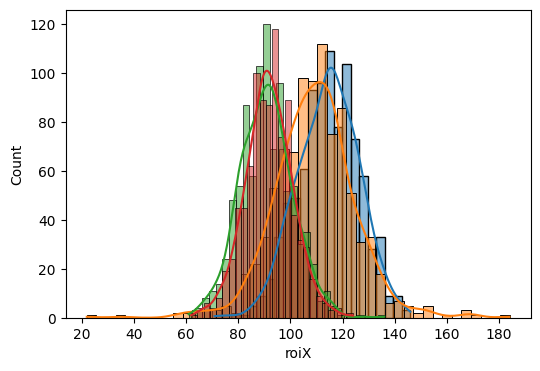

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = ["roiX", "roiY", "roiWidth", "roiHeight"]
plt.figure(figsize=(6, 4))
for col in numeric_columns:
    sns.histplot(df[col], kde=True)
plt.show()

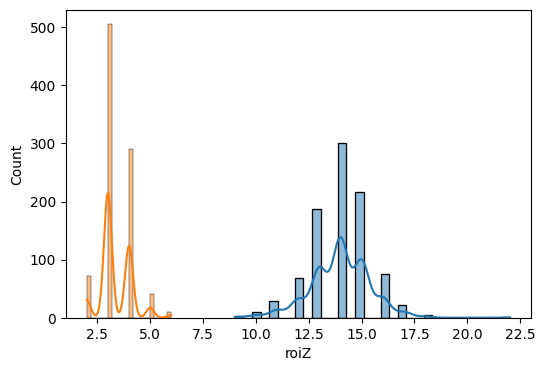

In [28]:
numeric_columns = ["roiZ", "roiDepth"]

plt.figure(figsize=(6, 4))
for col in numeric_columns:
    sns.histplot(df[col], kde=True)
plt.show()

Fitur-fitur di atas sekilas terlihat mendekati bentuk bell sehingga kita bisa asumsikan normal. Salah satu cara normalisasi ketika fitur kita normal adalah z-score normalization. Sebelum itu, kita hapus outlier yang dapat menggangu algoritma SVM dan KNN.

In [29]:
# outlier detection iqr method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [30]:
for col in ["roiX", "roiY", "roiWidth", "roiHeight", "roiZ", "roiDepth"]:
    outliers = detect_outliers(df, col)
    print(f"Outliers in {col}: {len(outliers)}")
    df = df.drop(outliers.index)

Outliers in roiX: 4
Outliers in roiY: 29
Outliers in roiWidth: 11
Outliers in roiHeight: 15
Outliers in roiZ: 4
Outliers in roiDepth: 8


In [31]:
df.shape

(846, 8)

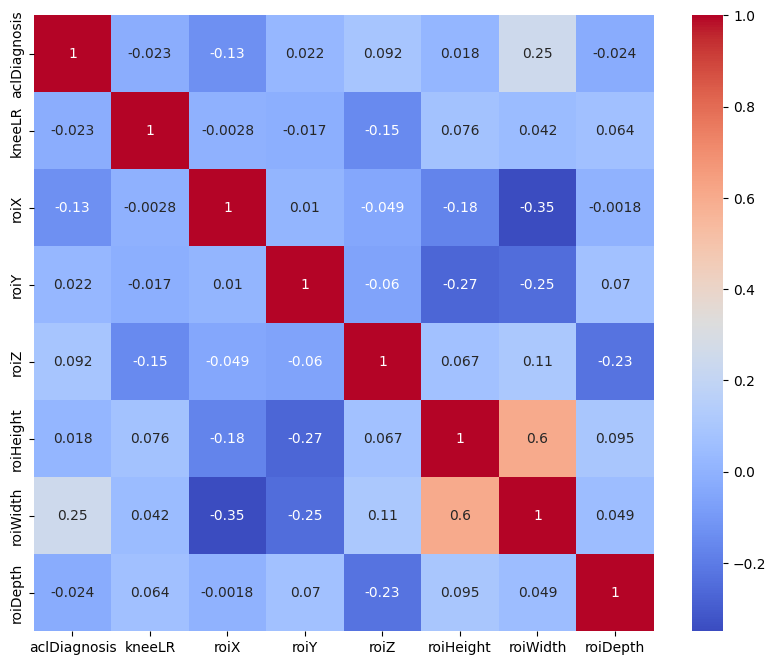

In [32]:
# heatmap korelasi antarfitur
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

Korelasi antarfitur tidak besar maka digunakan semua.

In [33]:
# normalization
numeric_columns = df.drop(['aclDiagnosis', 'kneeLR'], axis=1).columns.tolist()
scaler_data = {}

for col in numeric_columns:
  mean = df[col].mean()
  std = df[col].std()
  scaler_data[col] = {'mean': mean, 'std': std}
  if std != 0:
    df[col] = (df[col] - mean) / std
  else:
    df[col] = 0

df.head()

,aclDiagnosis,kneeLR,roiX,roiY,roiZ,roiHeight,roiWidth,roiDepth
2,1,1,0.471894,0.615967,0.747011,1.135998,2.653630,-1.968341
3,0,0,0.205450,1.166074,-1.504669,-0.103592,-1.171411,-0.485513
4,0,1,0.649523,-0.327073,-0.003549,-1.095264,0.795753,0.997316
5,1,0,-0.327439,1.873355,-0.754109,-1.715059,-1.389985,0.997316
7,0,0,-0.149809,0.537381,-2.255229,0.392244,-0.515689,-0.485513


In [34]:
# cek imbalance data
df['aclDiagnosis'].value_counts()

,count
aclDiagnosis,
0,642
1,155
2,49


In [35]:
# split to apply smote
X = df.drop(['aclDiagnosis'], axis=1)
y = df['aclDiagnosis']
print(X)
print(y)

     kneeLR      roiX      roiY      roiZ  roiHeight  roiWidth  roiDepth
2         1  0.471894  0.615967  0.747011   1.135998  2.653630 -1.968341
3         0  0.205450  1.166074 -1.504669  -0.103592 -1.171411 -0.485513
4         1  0.649523 -0.327073 -0.003549  -1.095264  0.795753  0.997316
5         0 -0.327439  1.873355 -0.754109  -1.715059 -1.389985  0.997316
7         0 -0.149809  0.537381 -2.255229   0.392244 -0.515689 -0.485513
..      ...       ...       ...       ...        ...       ...       ...
912       1 -0.149809  1.401835  1.497571   1.135998  0.905040 -0.485513
913       1 -0.860327 -0.562833 -0.003549   0.392244  1.014327 -0.485513
914       0  0.294264 -1.977394  0.747011   1.012039  1.014327 -1.968341
915       0 -0.860327 -0.955767  0.747011   1.383915  1.670048  0.997316
916       0 -0.149809 -0.091313 -0.003549   1.383915  2.107196  0.997316

[846 rows x 7 columns]
2      1
3      0
4      0
5      1
7      0
      ..
912    1
913    1
914    0
915    0
916    1
N

In [36]:
# smote
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

X_resampled, y_resampled = sm.fit_resample(X, y)
print(X_resampled, y_resampled)

      kneeLR      roiX      roiY      roiZ  roiHeight  roiWidth  roiDepth
0          1  0.471894  0.615967  0.747011   1.135998  2.653630 -1.968341
1          0  0.205450  1.166074 -1.504669  -0.103592 -1.171411 -0.485513
2          1  0.649523 -0.327073 -0.003549  -1.095264  0.795753  0.997316
3          0 -0.327439  1.873355 -0.754109  -1.715059 -1.389985  0.997316
4          0 -0.149809  0.537381 -2.255229   0.392244 -0.515689 -0.485513
...      ...       ...       ...       ...        ...       ...       ...
1921       0 -1.173086 -0.203018  0.312756   0.014165  1.912036 -0.485513
1922       0 -0.400212 -0.282225  0.505342   0.489594  2.544343 -0.485513
1923       0 -1.231078  0.150663 -1.367649   0.955968  0.785334  0.997316
1924       1  0.413438  0.169309 -0.260103   2.212412  2.058713  1.973289
1925       1  0.152673  0.243421  0.191164   1.934722  2.062367  2.095465

[1926 rows x 7 columns] 0       1
1       0
2       0
3       1
4       0
       ..
1921    2
1922    2
1923   

In [37]:
# dataframe setelah smote
df = pd.DataFrame(X_resampled, columns=X.columns)
df['aclDiagnosis'] = y_resampled
df

,kneeLR,roiX,roiY,roiZ,roiHeight,roiWidth,roiDepth,aclDiagnosis
0,1,0.471894,0.615967,0.747011,1.135998,2.653630,-1.968341,1
1,0,0.205450,1.166074,-1.504669,-0.103592,-1.171411,-0.485513,0
2,1,0.649523,-0.327073,-0.003549,-1.095264,0.795753,0.997316,0
3,0,-0.327439,1.873355,-0.754109,-1.715059,-1.389985,0.997316,1
4,0,-0.149809,0.537381,-2.255229,0.392244,-0.515689,-0.485513,0
...,...,...,...,...,...,...,...,...
1921,0,-1.173086,-0.203018,0.312756,0.014165,1.912036,-0.485513,2
1922,0,-0.400212,-0.282225,0.505342,0.489594,2.544343,-0.485513,2
1923,0,-1.231078,0.150663,-1.367649,0.955968,0.785334,0.997316,2
1924,1,0.413438,0.169309,-0.260103,2.212412,2.058713,1.973289,2


In [38]:
df['aclDiagnosis'].value_counts()

,count
aclDiagnosis,
1,642
0,642
2,642


In [39]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

In [40]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [41]:
for c in [0.1, 1, 10]:
  for kernel in ['linear', 'poly', 'rbf']:
    for gamma in ['scale', 'auto']:
      svm = None
      if kernel == 'poly':
        svm = SVC(C=c, kernel=kernel, gamma=gamma, degree=3, probability=True, random_state=42)
      else:
        svm = SVC(C=c, kernel=kernel, gamma=gamma, probability=True, random_state=42)
      scores = cross_val_score(svm, X_resampled, y_resampled, cv=skf, scoring='accuracy')
      print(f"C: {c}, Kernel: {kernel}, Gamma: {gamma}, Accuracy: {scores.mean()}")

C: 0.1, Kernel: linear, Gamma: scale, Accuracy: 0.486525798791019
C: 0.1, Kernel: linear, Gamma: auto, Accuracy: 0.486525798791019
C: 0.1, Kernel: poly, Gamma: scale, Accuracy: 0.5758041882556132
C: 0.1, Kernel: poly, Gamma: auto, Accuracy: 0.5612937176165802
C: 0.1, Kernel: rbf, Gamma: scale, Accuracy: 0.6095639032815199
C: 0.1, Kernel: rbf, Gamma: auto, Accuracy: 0.5882745034542314
C: 1, Kernel: linear, Gamma: scale, Accuracy: 0.48445056131260794
C: 1, Kernel: linear, Gamma: auto, Accuracy: 0.48445056131260794
C: 1, Kernel: poly, Gamma: scale, Accuracy: 0.6515786917098446
C: 1, Kernel: poly, Gamma: auto, Accuracy: 0.6370547279792746
C: 1, Kernel: rbf, Gamma: scale, Accuracy: 0.7103141191709844
C: 1, Kernel: rbf, Gamma: auto, Accuracy: 0.6921389248704662
C: 10, Kernel: linear, Gamma: scale, Accuracy: 0.4839297279792746
C: 10, Kernel: linear, Gamma: auto, Accuracy: 0.4839297279792746
C: 10, Kernel: poly, Gamma: scale, Accuracy: 0.6760092832469776
C: 10, Kernel: poly, Gamma: auto, Accur

Dari percobaan di atas disimpulkan parameter terbaik untuk tiap model sebagai berikut.

Linear: C = 0.1, Gamma = scale/auto

Cubic: C = 10, Gamma = scale

Rbf: C = 10, Gamma = scale

In [42]:
# SVM linear
svm_linear = SVC(kernel='linear', C=0.1, gamma="auto", probability=True, random_state=42)
linear_scores = cross_val_score(svm_linear, X_resampled, y_resampled, cv=skf, scoring='accuracy')
print(linear_scores.mean())

0.486525798791019


In [43]:
# # SVM Quadratic
# svm_quadratic = SVC(kernel='poly', degree=2, probability=True, random_state=42)
# quadratic_scores = cross_val_score(svm_quadratic, X_resampled, y_resampled, cv=skf, scoring='accuracy')
# print(quadratic_scores.mean())

In [44]:
# SVM Cubic
svm_cubic = SVC(kernel='poly', degree=3, C=10, gamma="scale", probability=True, random_state=42)
cubic_scores = cross_val_score(svm_cubic, X_resampled, y_resampled, cv=skf, scoring='accuracy')
print(cubic_scores.mean())

0.6760092832469776


In [45]:
# SVM RBF
svm_rbf = SVC(kernel='rbf', C=10, gamma="scale", probability=True, random_state=42)
rbf_scores = cross_val_score(svm_rbf, X_resampled, y_resampled, cv=skf, scoring='accuracy')
print(rbf_scores.mean())

0.802226360103627


In [46]:
estimators = [
    ('svm_linear', svm_linear),
    ('svm_cubic', svm_cubic),
    ('svm_rbf', svm_rbf)
]

In [47]:
stacking_svm = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_scores = cross_val_score(stacking_svm, X_resampled, y_resampled, cv=skf, scoring='accuracy')
print(stacking_scores.mean())

0.8058425086355785


In [48]:
# voting_svm = VotingClassifier(estimators=estimators, voting='hard')
# voting_scores = cross_val_score(voting_svm, X_resampled, y_resampled, cv=skf, scoring='accuracy')
# print(voting_scores.mean())

In [49]:
rf = rf_model = None
best_score = 0

for n_estimators in [100, 200, 300]:
  for criterion in ['gini', 'entropy']:
    for max_depth in [None, 5, 10, 15]:
      for min_samples_split in [2, 6, 10]:
        for min_samples_leaf in [1, 2, 4]:
          model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                      max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,
                                         random_state=42)
          scores = cross_val_score(model, X_resampled, y_resampled, cv=skf, scoring='accuracy')
          print(f"n_estimators: {n_estimators}, criterion: {criterion}, max_depth: {max_depth}, min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}, Accuracy: {scores.mean()}")

          if scores.mean() > best_score:
            rf = rf_model = model
            best_score = scores.mean()

print(best_score)

n_estimators: 100, criterion: gini, max_depth: None, min_samples_split: 2, min_samples_leaf: 1, Accuracy: 0.8686582469775475
n_estimators: 100, criterion: gini, max_depth: None, min_samples_split: 2, min_samples_leaf: 2, Accuracy: 0.8639950345423143
n_estimators: 100, criterion: gini, max_depth: None, min_samples_split: 2, min_samples_leaf: 4, Accuracy: 0.8359806778929189
n_estimators: 100, criterion: gini, max_depth: None, min_samples_split: 6, min_samples_leaf: 1, Accuracy: 0.8655494386873921
n_estimators: 100, criterion: gini, max_depth: None, min_samples_split: 6, min_samples_leaf: 2, Accuracy: 0.8551597582037995
n_estimators: 100, criterion: gini, max_depth: None, min_samples_split: 6, min_samples_leaf: 4, Accuracy: 0.8359806778929189
n_estimators: 100, criterion: gini, max_depth: None, min_samples_split: 10, min_samples_leaf: 1, Accuracy: 0.8510146804835925
n_estimators: 100, criterion: gini, max_depth: None, min_samples_split: 10, min_samples_leaf: 2, Accuracy: 0.847398531951640

Accuracy terbaik diperoleh dari 0.8821594343696028 dengan parameter sebagai berikut.

n_estimators: 200

criterion: entropy

max_depth: None

min_samples_split: 2

min_samples_leaf: 1

In [52]:
k_values = range(1, 16)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', metric="euclidean")
    scores = cross_val_score(knn, X_resampled, y_resampled, cv=skf, scoring='accuracy')
    cv_scores.append(scores.mean())

best_k = k_values[cv_scores.index(max(cv_scores))]
print(f'Best k Euclidean KNN: {best_k}, Accuracy: {max(cv_scores)}')

cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric="euclidean")
    scores = cross_val_score(knn, X_resampled, y_resampled, cv=skf, scoring='accuracy')
    cv_scores.append(scores.mean())

best_k = k_values[cv_scores.index(max(cv_scores))]
print(f'Best k Weighted KNN (Euclidean): {best_k}, Accuracy: {max(cv_scores)}')

cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric="manhattan")
    scores = cross_val_score(knn, X_resampled, y_resampled, cv=skf, scoring='accuracy')
    cv_scores.append(scores.mean())

best_k = k_values[cv_scores.index(max(cv_scores))]
print(f'Best k Weighted KNN (Manhattan): {best_k}, Accuracy: {max(cv_scores)}')

Best k Euclidean KNN: 1, Accuracy: 0.8541234887737478
Best k Weighted KNN (Euclidean): 1, Accuracy: 0.8541234887737478
Best k Weighted KNN (Manhattan): 1, Accuracy: 0.8639788428324697


In [54]:
# weighted KNN
knn_weighted = KNeighborsClassifier(n_neighbors=1, weights='distance', metric='euclidean')
weighted_scores = cross_val_score(knn_weighted, X_resampled, y_resampled, cv=skf, scoring='accuracy')
print(weighted_scores.mean())

0.8541234887737478


In [55]:
# Euclidian KNN
knn_euclidean = KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='euclidean')
euclidean_scores = cross_val_score(knn_euclidean, X_resampled, y_resampled, cv=skf, scoring='accuracy')
print(euclidean_scores.mean())

0.8541234887737478


In [56]:
# Manhattan KNN
knn_manhattan = KNeighborsClassifier(n_neighbors=1, weights='distance', metric='manhattan')
manhattan_scores = cross_val_score(knn_manhattan, X_resampled, y_resampled, cv=skf, scoring='accuracy')
print(manhattan_scores.mean())

0.8639788428324697


In [57]:
estimators = [
    ('knn_weighted', knn_weighted),
    ('knn_euclidean', knn_euclidean),
    ('knn_manhattan', knn_manhattan)
]

In [59]:
# stacking knn
stacking_knn = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_scores = cross_val_score(stacking_knn, X_resampled, y_resampled, cv=skf, scoring='accuracy')
print(stacking_scores.mean())

0.8790506260794473


In [60]:
models = {
    "Random Forest": rf_model,
    "Stacking SVM": stacking_svm,
    "Stacking KNN": stacking_knn
}

In [61]:
print("====================")
print("EVALUATION")
print("====================")
for name, model in models.items():
  print(f"Model: {name}")

  y_pred = cross_val_predict(model, X_resampled, y_resampled, cv=skf)

  accuracy = accuracy_score(y_resampled, y_pred)
  precision = precision_score(y_resampled, y_pred, average='macro')
  recall = recall_score(y_resampled, y_pred, average='macro')
  f1 = f1_score(y_resampled, y_pred, average='macro')

  print(f"Accuracy: {accuracy}")
  print(f"Precision (macro): {precision}")
  print(f"Recall (macro): {recall}")
  print(f"F1 Score (macro): {f1}")
  print("\nDetailed Classification Report:")
  print(classification_report(y_resampled, y_pred, digits=4))

  print("=" * 50)

EVALUATION
Model: Random Forest
Accuracy: 0.8821391484942886
Precision (macro): 0.8813960182538793
Recall (macro): 0.8821391484942888
F1 Score (macro): 0.881173280107343

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.8725    0.8209    0.8459       642
           1     0.8666    0.8598    0.8632       642
           2     0.9051    0.9657    0.9344       642

    accuracy                         0.8821      1926
   macro avg     0.8814    0.8821    0.8812      1926
weighted avg     0.8814    0.8821    0.8812      1926

Model: Stacking SVM
Accuracy: 0.8058151609553479
Precision (macro): 0.8056564703386592
Recall (macro): 0.805815160955348
F1 Score (macro): 0.804581109622409

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.7909    0.7072    0.7467       642
           1     0.7383    0.7866    0.7617       642
           2     0.8877    0.9237    0.9053       642

    accu

CONFUSION MATRIX


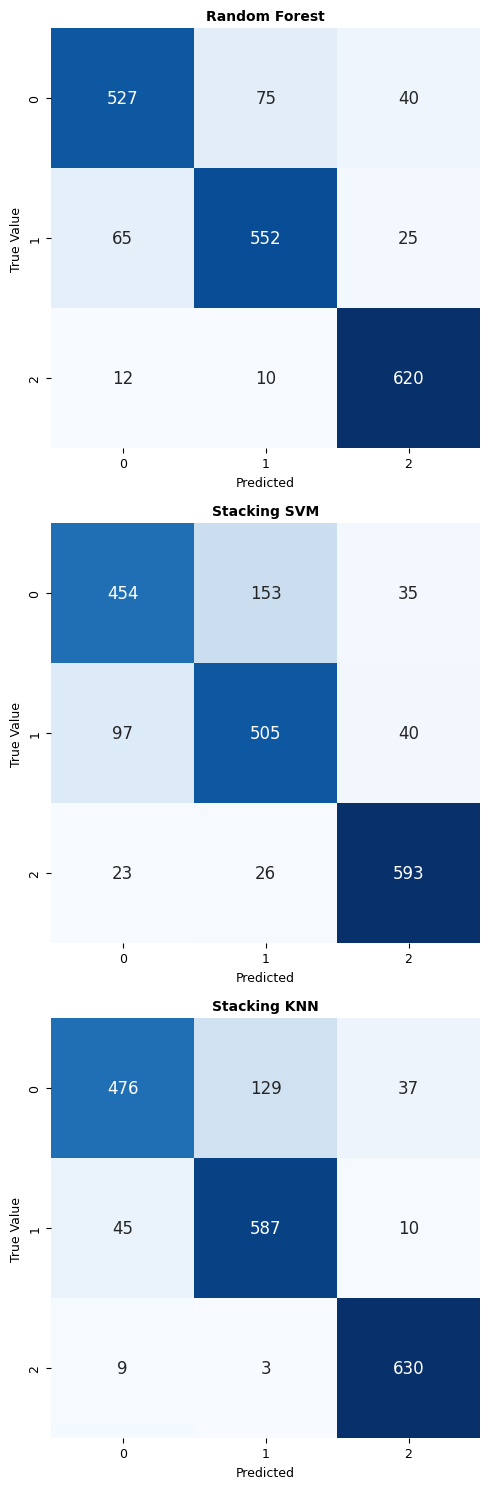

In [66]:
from sklearn.metrics import confusion_matrix

print("====================")
print("CONFUSION MATRIX")
print("====================")
fig, axes = plt.subplots(3, 1, figsize=(5, 15))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    y_pred = cross_val_predict(model, X_resampled, y_resampled, cv=skf)
    cm = confusion_matrix(y_resampled, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx], annot_kws={'size': 12})
    axes[idx].set_xlabel("Predicted", fontsize=9)
    axes[idx].set_ylabel("True Value", fontsize=9)
    axes[idx].set_title(name, fontsize=10, fontweight="bold")
    axes[idx].set_xticklabels(
      axes[idx].get_xticklabels(),
      fontsize=9,
    )
    axes[idx].set_yticklabels(
      axes[idx].get_yticklabels(),
      fontsize=9,
    )

plt.tight_layout()
plt.show()

In [64]:
rf_model.fit(X_resampled, y_resampled)
stacking_svm.fit(X_resampled, y_resampled)
stacking_knn.fit(X_resampled, y_resampled)

StackingClassifier(estimators=[('knn_weighted',
                                KNeighborsClassifier(metric='euclidean',
                                                     n_neighbors=1,
                                                     weights='distance')),
                               ('knn_euclidean',
                                KNeighborsClassifier(metric='euclidean',
                                                     n_neighbors=1)),
                               ('knn_manhattan',
                                KNeighborsClassifier(metric='manhattan',
                                                     n_neighbors=1,
                                                     weights='distance'))],
                   final_estimator=LogisticRegression())

In [65]:
import joblib

joblib.dump(scaler_data, 'models/scaler_data.pkl')

for name, model in models.items():
  joblib.dump(model, f'models/{name}.pkl')